<a href="https://colab.research.google.com/github/SpirinEgor/HSE.Deep_Unsupervised_Learning/blob/hw9/Homework/hw9/Homework9_ebm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Feb  1 19:10:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw9

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 832 (delta 165), reused 183 (delta 106), pack-reused 526
Receiving objects: 100% (832/832), 74.32 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (397/397), done.
/content/HSE.Deep_Unsupervised_Learning
Branch 'hw9' set up to track remote branch 'hw9' from 'origin'.
Switched to a new branch 'hw9'


In [3]:
! pip install -q -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from utils.hw9_utils import *
from ebm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1: EBM on MNIST

Here we will implement EBM on MNIST data. 

* **Architecture.** You may experiment with different hyperparameters and architecture designs, but 
the following designs for the EBM architecture may be useful.

```
    Conv2d(1, 16, 5, 2, 4), 
    Swish(),
    Conv2d(16, 32, 3, 2, 1),
    Swish(), 
    Conv2d(32, 64, 3, 2, 1), 
    Swish(), 
    Conv2d(64, 64, 3, 2, 1), 
    Swish(),
    Flatten(),
    Linear(256, 64), 
    Swish(),
    Linear(64, 1)
```


Where `swish(x) = σ(x)x`. You **should** use activation with non-sparse gradients for better MCMC convergence.

* **Buffer.** To use the contrastive divergence objective, we need to generate samples during training. Because of high dimension of image space we need a lot of iterations in MCMC to obtain reasonable samples. We can reduce sampling cost with buffer trick. The idea of this trick it to re-use previous samples as starting points for MCMC (since distribuionts are close). In our implementation, we initialize 95% of starting points with previous samples and 5% with random noise from -1 to 1. 

* **MCMC.** During MCMC procedure you only need gradients wrt input. You can find it helpful to disable gradients of your model during MCMC. Since all images are in [-1, 1] you should clamp all resulting points during MCMC step. We also clamp gradients to [-0.03, 0.03].
    ```
    for p in model.parameters():
        p.requires_grad = False
    ```

* **Regularizations.**

 You should add small noise to real data otherwise ebm will focus on black areas of real images won't train.

 Add l2 regularaztion to ebm outputs on real and fake data. Otherwise, the output values will fluctuate in a very large range (because energy is invariant to scalar shift).

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 10
    * MCMC # step - 60
    * MCMC noise - N(0, 0.005)
    * Noise to data - N(0, 0.005)
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can exponential scheduler
    * 20 epochs should be enough (~1 hour on gpu)



**You will provide the following deliverables**


1.   Over the course of training, record the regularization and contrastive losses per batch.
2. 100 samples from your trained EBM

In [14]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array full of contrastive losses on each iteration
    - a (# of training iterations, ) numpy array full of regularization losses on each iteration
    - a (100, 28, 28, 1) numpy array of 100 samples from ebm model
    """
    buffer = Buffer(8192, device)
    ebm = EBM(buffer).to(device)
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

    con_losses, reg_losses = train_ebm(ebm, train_dataloader, 5, device=device)
    return con_losses, reg_losses, ebm.langevin_sample(100).detach().cpu().numpy()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

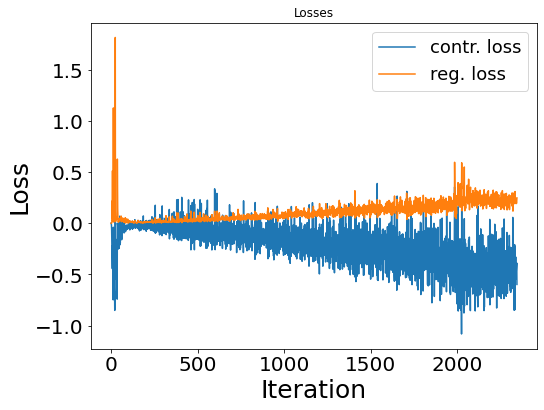

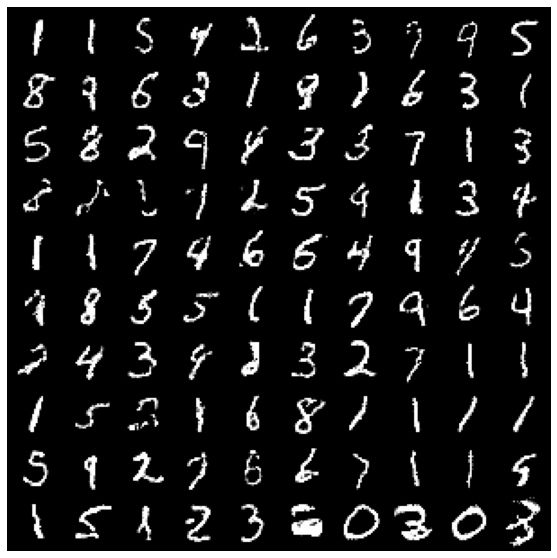

In [15]:
q1_results(q1)

# Question 2: EBM conditional generation

Here we will train EBM jointly with classifier to generate objects conditioned on class labels. ([original paper](https://arxiv.org/pdf/1912.03263.pdf)).

* **Theory**. Here we will work with joint distribution on x (data point) and y (label). We will parametrize probability of the pair as follows

```
p_θ(x, y) = exp(f_θ(x)[y]) / Z(θ)
```
Where `f(x)[y]` is an y-th output of the classifier model and `Z(θ)` is a normalization constant.

We will optimize log-likelihood of train pair:

```
log p(x, y) = log p(x) + log p(y|x)
```

Second term corresponds to normal classification loss and we will optimize it with cross entropy. We will optimize first tirm via contrastive divergence. The energy of can be from classifire output : `E(x)=-log ∑ exp(f_θ(x)[y])`.

* **Architecture.** We will work with smile dataset and you can use architecture from practice.

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 0.1
    * MCMC # step - 500 (during final sampling you can increase it)
    * MCMC noise - N(0, 0.005)
    * Noise to data - None
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can use exponential scheduler
    * 100 epochs should be enough (~10 minutes on cpu)



**You will provide the following deliverables**


1.   Over the course of training, record loss per batch.
3. 300 samples from your trained EBM. First 100 samples should be generated for label 0, next 100 for label 1, and last 100 for label 2

In [9]:
def q2(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """
    dataset = torch.utils.data.TensorDataset(torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_labels))
    train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    buffer = Buffer(8192, device, sizes=(2,))
    c_ebm = ConditionalEBM(2, 3, buffer).to(device)

    losses = train_conditional_ebm(c_ebm, train_dataloader, n_epochs=50, device=device)

    samples = [c_ebm.langevin_sample(100, i, n_iter=1500).detach().cpu().numpy() for i in tqdm([0, 1, 2], desc="Sampling")]
    samples = np.vstack(samples)

    return losses, samples

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/3 [00:00<?, ?it/s]

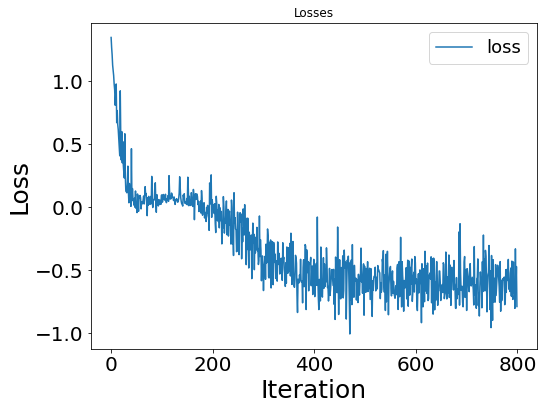

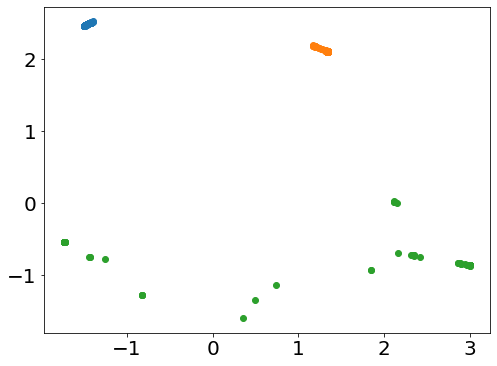

In [10]:
q2_results(q2)

# Bonus : Conditional generation with EBM and classifier.

Here you need to generate points conditioned on class on smile dataset with independently trained ebm and classifier. For generation use MCMC with

```
log p(x|y) ~ log p(x) + log p(y|x)
```

Where first term is `-E(x)` and second is obtained via backprop from trained classifier.

In [ ]:
def b(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses of classfier on each iteration
    - a (# of training iterations, ) numpy array full of losses of ebm on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """
    pass

In [ ]:
b_results(b)